<a href="https://colab.research.google.com/github/Eambr/little_lab/blob/main/Little_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Cosa faremo
Scarichiamo i dati di un sistema binario, Her X-1
presi dal satellite Swift/BAT.


## 🧠 Istruzioni
1. Apri questo notebook su **Google Colab**.
2. Carica i file di dati `.txt` usando la cella qui sotto.
3. Esamina i dati e prova a fare alcune semplici analisi.


In [ ]:
import pandas as pd

url = "https://swift.gsfc.nasa.gov/results/transients/HerX-1.lc.txt"

# Legge il file, ignorando tutte le righe di commento che iniziano con '#'
df = pd.read_csv(url, delim_whitespace=True, skiprows =[0, 1, 2, 4], usecols= (0,1,2))



# Mostra le prime righe
print(df.head())


/tmp/ipython-input-4239503236.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, skiprows =[0, 1, 2, 4], usecols= (0,1,2))


       #      TIME      RATE
0  53416  0.000242  0.000831
1  53417  0.002810  0.001599
2  53419  0.010767  0.001972
3  53420  0.006777  0.002047
4  53421  0.008655  0.002057


In [ ]:
#cosa vediamo?
df.keys()

Index(['#', 'TIME', 'RATE'], dtype='object')

Rinomiamo le colonne

In [ ]:

df.rename(columns={"#": "time", "TIME": "rate", "RATE": "error"}, inplace=True)

In [ ]:
df.keys()
df = df.apply(pd.to_numeric, errors='coerce')

# Rimuove eventuali righe con valori NaN
df = df.dropna()

In [ ]:
df

,time,rate,error
0,53416,0.000242,0.000831
1,53417,0.002810,0.001599
2,53419,0.010767,0.001972
3,53420,0.006777,0.002047
4,53421,0.008655,0.002057
...,...,...,...
7026,60965,0.004246,0.002063
7027,60966,0.003192,0.003078
7028,60967,-0.000311,0.002345
7029,60968,0.001214,0.001854


Ora visualizziamo i dati che abbiamo scaricato.
In gergo diremo che 'plottiamo' i dati.
Vogliamo capire come varia la curva di luce nel tempo:
quindi sull'asse X mettiamo il tempo
sull'asse y i conteggi/al seconodo (detti anche count-rate):
ossia il Numero di fotoni che colpiscono il detector

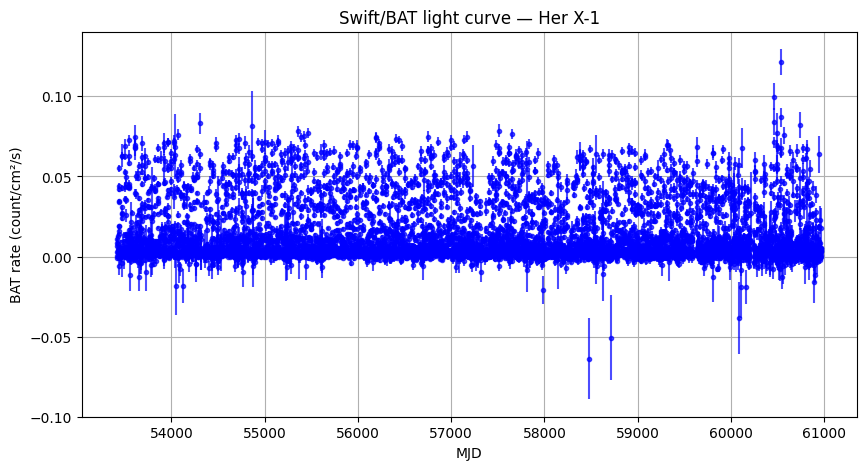

In [ ]:
#Libreria per fare i grafici : matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(10,5))
plt.errorbar(df['time'], df['rate'], yerr=df['error'], fmt=".", alpha=0.7, color="blue")
plt.xlabel("MJD")
plt.ylabel("BAT rate (count/cm²/s)")
plt.title("Swift/BAT light curve — Her X-1")
plt.grid(True)
plt.show()

Gli astronomi per comodità non utilizzano le date nel modo un cui siamo abituati: ossia giorno, mese anno, ora.
Bensì utilizzano un 'tempo standard', che ogni tanto si rinnova.

Al momento utilizziamo il MJD (little introduction on that)

Vogliamo capire a cosa corrispondono quei giorni
sul nostro calendario:


In [ ]:
from astropy.time import Time
t = Time(df["time"], format="mjd")
t.isot

array(['2005-02-15T00:00:00.000', '2005-02-16T00:00:00.000',
       '2005-02-18T00:00:00.000', ..., '2025-10-19T00:00:00.000',
       '2025-10-20T00:00:00.000', '2025-10-21T00:00:00.000'], dtype='<U23')

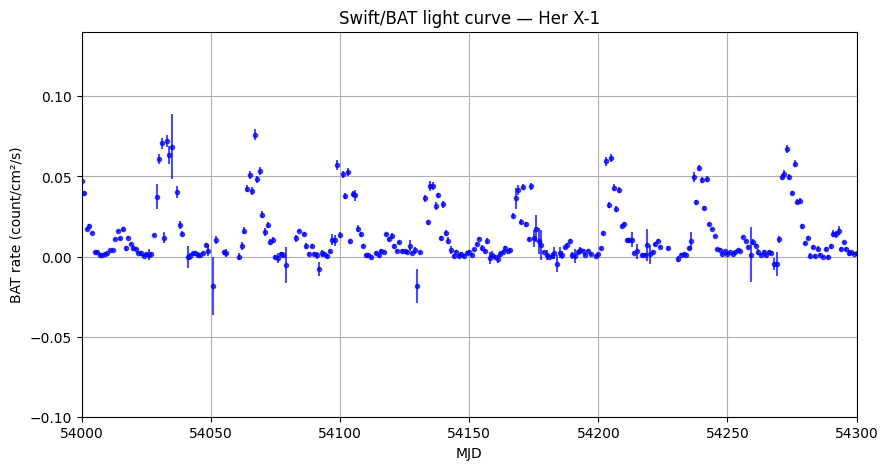

In [ ]:
plt.figure(figsize=(10,5))
plt.errorbar(df['time'], df['rate'], yerr=df['error'], fmt=".", alpha=0.7, color="blue")
plt.xlabel("MJD")
plt.ylabel("BAT rate (count/cm²/s)")
plt.title("Swift/BAT light curve — Her X-1")
plt.xlim(54000,54300)
plt.grid(True)
plt.show()

In [ ]:
 df['time'].max() - df['time'].min()

7553

In [ ]:
Psup = 35.1
Porb = 1.7

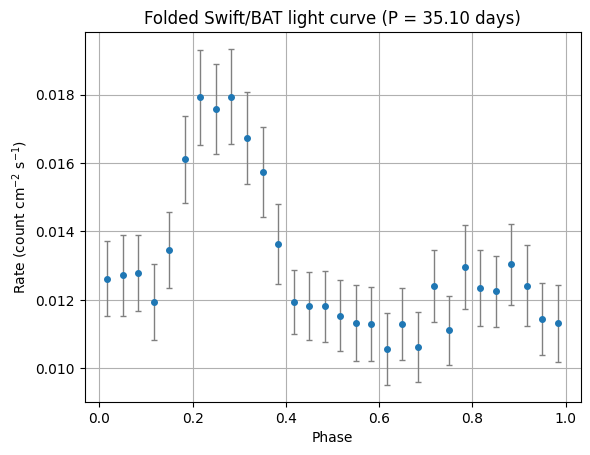

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# === PARAMETERS ===
P = 35.1        # Period in days
t0 = df["time"].min()  # Reference epoch (you can change it)

# === Compute phase ===
df["phase"] = ((df["time"] - t0) / P) % 1.0

# === Bin the data in phase ===
nbins = 30
bins = np.linspace(0, 1, nbins + 1)
bin_means, _, _ = stats.binned_statistic(df["phase"], df["rate"], statistic="mean", bins=bins)
bin_stds, _, _ = stats.binned_statistic(df["phase"], df["rate"], statistic="std", bins=bins)
bin_counts, _, _ = stats.binned_statistic(df["phase"], df["rate"], statistic="count", bins=bins)
bin_err = bin_stds / np.sqrt(bin_counts)   # Standard error of mean

# === Compute bin centers ===
phase_centers = 0.5 * (bins[1:] + bins[:-1])

# === Plot folded light curve ===
plt.errorbar(phase_centers, bin_means, yerr=bin_err, fmt='o', color='C0',
             ecolor='gray', elinewidth=1, capsize=2, markersize=4)
plt.xlabel("Phase")
plt.ylabel("Rate (count cm$^{-2}$ s$^{-1}$)")
plt.title(f"Folded Swift/BAT light curve (P = {P:.2f} days)")
plt.grid(True)
plt.show()


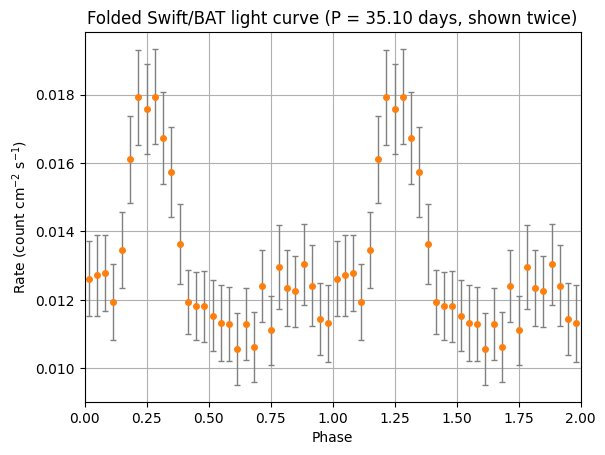

In [ ]:
# === Duplicate folded curve for two cycles (0–2) ===

phase_double = np.concatenate([phase_centers, phase_centers + 1.0])
rate_double = np.concatenate([bin_means, bin_means])
err_double = np.concatenate([bin_err, bin_err])

plt.errorbar(phase_double, rate_double, yerr=err_double, fmt='o', color='C1',
             ecolor='gray', elinewidth=1, capsize=2, markersize=4)
plt.xlabel("Phase")
plt.ylabel("Rate (count cm$^{-2}$ s$^{-1}$)")
plt.title(f"Folded Swift/BAT light curve (P = {P:.2f} days, shown twice)")
plt.grid(True)
plt.xlim(0, 2)
plt.show()


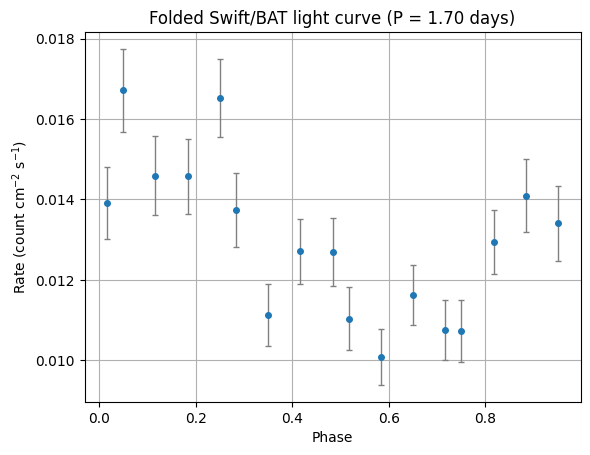

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# === PARAMETERS ===
P = Porb      # Period in days
t0 = df["time"].min()  # Reference epoch (you can change it)

# === Compute phase ===
df["phase"] = ((df["time"] - t0) / P) % 1.0

# === Bin the data in phase ===
nbins = 30
bins = np.linspace(0, 1, nbins + 1)
bin_means, _, _ = stats.binned_statistic(df["phase"], df["rate"], statistic="mean", bins=bins)
bin_stds, _, _ = stats.binned_statistic(df["phase"], df["rate"], statistic="std", bins=bins)
bin_counts, _, _ = stats.binned_statistic(df["phase"], df["rate"], statistic="count", bins=bins)
bin_err = bin_stds / np.sqrt(bin_counts)   # Standard error of mean

# === Compute bin centers ===
phase_centers = 0.5 * (bins[1:] + bins[:-1])

# === Plot folded light curve ===
plt.errorbar(phase_centers, bin_means, yerr=bin_err, fmt='o', color='C0',
             ecolor='gray', elinewidth=1, capsize=2, markersize=4)
plt.xlabel("Phase")
plt.ylabel("Rate (count cm$^{-2}$ s$^{-1}$)")
plt.title(f"Folded Swift/BAT light curve (P = {P:.2f} days)")
plt.grid(True)
plt.show()


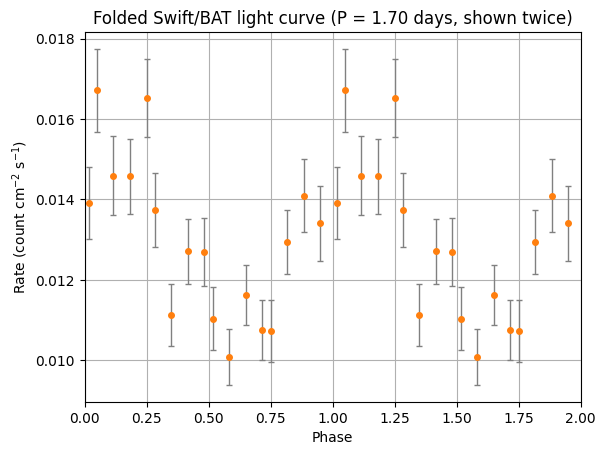

In [ ]:
# === Duplicate folded curve for two cycles (0–2) ===

phase_double = np.concatenate([phase_centers, phase_centers + 1.0])
rate_double = np.concatenate([bin_means, bin_means])
err_double = np.concatenate([bin_err, bin_err])

plt.errorbar(phase_double, rate_double, yerr=err_double, fmt='o', color='C1',
             ecolor='gray', elinewidth=1, capsize=2, markersize=4)
plt.xlabel("Phase")
plt.ylabel("Rate (count cm$^{-2}$ s$^{-1}$)")
plt.title(f"Folded Swift/BAT light curve (P = {P:.2f} days, shown twice)")
plt.grid(True)
plt.xlim(0, 2)
plt.show()


Ora tocca a voi:
Istruzioni:
L'elenco dei sistemi binari monitorati dallo strumento BAT si
trova in questa [pagina](https://swift.gsfc.nasa.gov/results/transients/)

1. scegli un sistema binario tra:


*   LMC X-4
*   Cep X-4
3. trova la sua curva di luce
2. plotta la curva di luce intera
3. plotta la curva di luce in un range di date
4. riesci a trovare una certa periodicità?



